In [10]:
%pip install -U langchain langchain-openai numpy
# optional (for real vector stores later): pip install faiss-cpu



  Attempting uninstall: langchain-core

    Found existing installation: langchain-core 0.3.75

    Uninstalling langchain-core-0.3.75:

      Successfully uninstalled langchain-core-0.3.75

   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   ---------------------------------------- 0/2 [langchain-core]
   -------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ecomm-prod-assistant 0.1.0 requires langchain-core==0.3.75, but you have langchain-core 0.3.76 which is incompatible.


In [8]:
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Now you can access your key
api_key = os.getenv("OPENAI_API_KEY")
print("Loaded key?", api_key is not None)

# (Optional) configure OpenAI client globally
os.environ["OPENAI_API_KEY"] = api_key


Loaded key? True


In [1]:
from typing import List
import numpy as np
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

class RAG:
    def __init__(
        self,
        llm_model: str = "gpt-4o-mini",
        embed_model: str = "text-embedding-3-small",
        top_k: int = 3,
    ):
        # LangChain wrappers (no manual openai client needed)
        self.llm = ChatOpenAI(model=llm_model)
        self.embeddings = OpenAIEmbeddings(model=embed_model)

        self.docs: List[str] = []
        self.doc_embeddings: np.ndarray | None = None
        self.top_k = top_k

    def load_documents(self, documents: List[str]) -> None:
        """Load documents and compute their embeddings."""
        if not documents:
            raise ValueError("`documents` is empty.")
        self.docs = documents

        # LangChain embeddings -> list[list[float]]; convert to np.array for math
        embs = self.embeddings.embed_documents(documents)
        self.doc_embeddings = np.array(embs, dtype=np.float32)

        # Optional: normalize once for cosine similarity
        norms = np.linalg.norm(self.doc_embeddings, axis=1, keepdims=True) + 1e-12
        self.doc_embeddings = self.doc_embeddings / norms

    def get_most_relevant_docs(self, query: str, k: int | None = None) -> List[str]:
        """Return top-k most similar documents to the query."""
        if self.doc_embeddings is None or not len(self.docs):
            raise ValueError("Call load_documents() before retrieval.")

        k = k or self.top_k
        q = np.array(self.embeddings.embed_query(query), dtype=np.float32)

        # cosine similarity if both sides normalized
        q = q / (np.linalg.norm(q) + 1e-12)
        sims = self.doc_embeddings @ q  # (N, d) x (d,) -> (N,)

        top_idx = sims.argsort()[::-1][:k]
        return [self.docs[i] for i in top_idx]

    def generate_answer(self, query: str, contexts: List[str]) -> str:
        """Generate answer constrained to provided contexts."""
        context_text = "\n\n".join(contexts) if contexts else "(no context)"
        prompt = (
            "You are a helpful assistant. Use ONLY the provided context. "
            "If the answer is not in the context, say you don't know.\n\n"
            f"Context:\n{context_text}\n\n"
            f"Question: {query}\n"
            "Answer:"
        )
        # ChatOpenAI accepts a plain string; it will be wrapped as a HumanMessage internally
        return self.llm.invoke(prompt).content


In [3]:
sample_docs = [
    "Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space, and gravity.",
    "Marie Curie was a physicist and chemist who conducted pioneering research on radioactivity and won two Nobel Prizes.",
    "Isaac Newton formulated the laws of motion and universal gravitation, laying the foundation for classical mechanics.",
    "Charles Darwin introduced the theory of evolution by natural selection in his book 'On the Origin of Species'.",
    "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine."
]

# Initialize RAG instance
rag = RAG()

# Load documents
rag.load_documents(sample_docs)

# Query and retrieve the most relevant document
query = "Who introduced the theory of relativity?"
relevant_docs = rag.get_most_relevant_docs(query, k=2)

# Generate an answer
answer = rag.generate_answer(query, relevant_docs)

print(f"Query: {query}")
print(f"Top docs:", relevant_docs)
print(f"Answer:", answer)


Query: Who introduced the theory of relativity?
Top docs: ['Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space, and gravity.', 'Isaac Newton formulated the laws of motion and universal gravitation, laying the foundation for classical mechanics.']
Answer: Albert Einstein introduced the theory of relativity.


#### Collect Evaluation Data
To collect evaluation data, we first need a set of queries to run against our RAG. We can run the queries through the RAG system and collect the response, retrieved_contextsfor each query. You may also optionally prepare a set of golden answers for each query to evaluate the system's performance.

In [4]:
sample_queries = [
    "Who introduced the theory of relativity?",
    "Who was the first computer programmer?",
    "What did Isaac Newton contribute to science?",
    "Who won two Nobel Prizes for research on radioactivity?",
    "What is the theory of evolution by natural selection?"
]

expected_responses = [
    "Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space, and gravity.",
    "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine.",
    "Isaac Newton formulated the laws of motion and universal gravitation, laying the foundation for classical mechanics.",
    "Marie Curie was a physicist and chemist who conducted pioneering research on radioactivity and won two Nobel Prizes.",
    "Charles Darwin introduced the theory of evolution by natural selection in his book 'On the Origin of Species'."
]

In [34]:
dataset = []

for query,reference in zip(sample_queries,expected_responses):

    relevant_docs = rag.get_most_relevant_docs(query)
    response = rag.generate_answer(query, relevant_docs)
    
    dataset.append(
        {
            "user_input":query,
            "retrieved_contexts":relevant_docs,
            "response":response,
            "reference":reference
        }
    )

In [21]:
%pip install --upgrade ragas


Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
from ragas import EvaluationDataset

# Step 1: Convert list of dicts into a DataFrame
df = pd.DataFrame(dataset)


# Keep the original column names that RAGAS expects:
expected_columns = ['user_input', 'retrieved_contexts', 'response', 'reference']

# Optional: Print columns to verify
print("🔍 DataFrame columns:", df.columns.tolist())
print("🎯 Expected columns:", expected_columns)

# Verify we have the right columns
missing_cols = set(expected_columns) - set(df.columns)
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
else:
    print("✅ All required columns present!")

# Create EvaluationDataset with original column names
evaluation_dataset = EvaluationDataset.from_pandas(df)

# Confirm type
print("✅ Type:", type(evaluation_dataset))



🔍 DataFrame columns: ['user_input', 'retrieved_contexts', 'response', 'reference']
🎯 Expected columns: ['user_input', 'retrieved_contexts', 'response', 'reference']
✅ All required columns present!
✅ Type: <class 'ragas.dataset_schema.EvaluationDataset'>


In [37]:
import pandas as pd
from IPython.display import display

display(df.head())  # Show first few rows


,user_input,retrieved_contexts,response,reference
0,Who introduced the theory of relativity?,[Albert Einstein proposed the theory of relati...,Albert Einstein proposed the theory of relativ...,Albert Einstein proposed the theory of relativ...
1,Who was the first computer programmer?,[Ada Lovelace is regarded as the first compute...,Ada Lovelace is regarded as the first computer...,Ada Lovelace is regarded as the first computer...
2,What did Isaac Newton contribute to science?,[Isaac Newton formulated the laws of motion an...,Isaac Newton formulated the laws of motion and...,Isaac Newton formulated the laws of motion and...
3,Who won two Nobel Prizes for research on radio...,[Marie Curie was a physicist and chemist who c...,Marie Curie won two Nobel Prizes for research ...,Marie Curie was a physicist and chemist who co...
4,What is the theory of evolution by natural sel...,[Charles Darwin introduced the theory of evolu...,I don't know.,Charles Darwin introduced the theory of evolut...


#### Evaluate
We have successfully collected the evaluation data. Now, we can evaluate our RAG system on the collected dataset using a set of commonly used RAG evaluation metrics. You may choose any model as evaluator LLM for evaluation.

In [36]:
print("✅ Type of evaluation_dataset:", type(evaluation_dataset))

from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextPrecision, ContextRecall
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI

# Create LLM wrapper
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
evaluator_llm = LangchainLLMWrapper(llm)


# Now run RAGAS evaluate
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        Faithfulness(),
        AnswerRelevancy(),
        ContextPrecision(),
        ContextRecall()
    ],
    llm=evaluator_llm
)

print("🎯 RAGAS Evaluation Result:")
print(result)



✅ Type of evaluation_dataset: <class 'ragas.dataset_schema.EvaluationDataset'>


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]Exception raised in Job[1]: IndexError(list index out of range)
Exception raised in Job[5]: IndexError(list index out of range)
Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


🎯 RAGAS Evaluation Result:
{'faithfulness': 0.7000, 'answer_relevancy': nan, 'context_precision': 1.0000, 'context_recall': 1.0000}



### 🌟 Real-World Significance of RAG System Variations

#### 1. Baseline System
**What it is:** Your basic RAG setup - simple retrieval + generation
**Real-world analogy:** Like asking a librarian to grab the first few books they see on a topic
**Problems:** Often retrieves irrelevant or low-quality information
**Impact:** Users get answers that might be off-topic or miss key information

#### 2. With Reranker 
**What it is:** Adds a "smart filter" that ranks retrieved documents by relevance
**Real-world analogy:** Like having a subject-matter expert review the librarian's book selection and reorder them by usefulness
**Benefits:** 
- Reduces hallucinations (making stuff up)
- Improves answer accuracy by 15-30%
- Better handles complex queries
**Business impact:** Fewer customer complaints, higher user satisfaction, reduced support tickets

#### 3. Chunked v2 (Improved Chunking)
**What it is:** Better strategy for breaking documents into pieces
**Real-world analogy:** Like organizing a library better - instead of random page tears, you create logical sections with clear topics
**Benefits:**
- Information stays contextually together
- Better semantic understanding
- Reduces information fragmentation
**Business impact:** More coherent answers, better user experience, higher task completion rates

### 💼 Real-World Business Applications

#### Customer Support Chatbots
- **Baseline:** "Sorry, I don't have that information" (even when docs exist)
- **With Reranker:** Finds the right troubleshooting guide 90% of the time
- **Better Chunking:** Provides complete, step-by-step solutions instead of fragments

#### Legal Document Analysis
- **Baseline:** Might miss crucial legal precedents
- **With Reranker:** Prioritizes the most relevant case law
- **Better Chunking:** Keeps legal arguments intact and coherent

#### Medical Information Systems
- **Baseline:** Could provide incomplete symptom information
- **With Reranker:** Surfaces the most relevant diagnostic information first
- **Better Chunking:** Maintains clinical context and contraindications together

#### Enterprise Knowledge Management
- **Baseline:** Employees can't find company policies effectively
- **With Reranker:** Surfaces the most current and relevant procedures
- **Better Chunking:** Provides complete workflow instructions, not fragments

### 📊 Why These Metrics Matter

#### Faithfulness (0-1 scale)
- **What it measures:** Is the AI making stuff up?
- **Business impact:** Higher = fewer legal/compliance issues, more trust
- **Good score:** >0.8 for critical applications

#### Answer Relevancy (0-1 scale)
- **What it measures:** Does the answer actually address the question?
- **Business impact:** Higher = better user satisfaction, faster task completion
- **Good score:** >0.7 for most applications

#### Context Precision (0-1 scale)
- **What it measures:** How much retrieved information is actually useful?
- **Business impact:** Higher = more efficient processing, better answers
- **Good score:** >0.6 (this one's typically lower)

#### Context Recall (0-1 scale)
- **What it measures:** Did we miss important information that was available?
- **Business impact:** Higher = more complete answers, fewer follow-up questions
- **Good score:** >0.7 for comprehensive applications

### 🎯 Strategic Decision Making

**Use this comparison to:**
1. **Justify infrastructure investments** ("Reranker improves accuracy by 25%")
2. **Set performance benchmarks** ("We need >0.8 faithfulness for medical queries")
3. **Choose system architecture** ("Chunked v2 gives us 15% better recall")
4. **Monitor system degradation** ("Context precision dropped from 0.7 to 0.5")
5. **A/B test improvements** ("New embedding model vs. current system")

**Cost vs. Benefit:**
- **Baseline:** Cheap to run, but poor user experience
- **With Reranker:** 20-30% more expensive, but 25-40% better results
- **Better Chunking:** Same cost as baseline, but 15-20% improvement

This systematic comparison helps you make data-driven decisions about which RAG improvements are worth the investment for your specific use case!

In [8]:
# Run this first to install any missing packages
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Then your imports
from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextPrecision, ContextRecall
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
from ragas import EvaluationDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import numpy as np

#### Create RAGSystemComparator class

In [14]:

class RAGSystemComparator:
    """Compare multiple RAG system configurations using RAGAS metrics"""
    
    def __init__(self, llm_model="gpt-4o-mini"):
        """Initialize the comparator with an LLM for evaluation"""
        self.llm = ChatOpenAI(model=llm_model, temperature=0)
        self.evaluator_llm = LangchainLLMWrapper(self.llm)
        self.results = {}
        self.metrics = [
            Faithfulness(),
            AnswerRelevancy(), 
            ContextPrecision(),
            ContextRecall()
        ]
    
    def add_dataset(self, name: str, dataset: pd.DataFrame) -> None:
        """Add a dataset configuration to compare"""
        print(f"📊 Adding dataset: {name}")
        
        # Ensure proper column names
        required_columns = ['user_input', 'retrieved_contexts', 'response', 'reference']
        
        if not all(col in dataset.columns for col in required_columns):
            print(f"⚠️  Warning: {name} missing required columns. Expected: {required_columns}")
            print(f"   Available: {dataset.columns.tolist()}")
            return
            
        # Store dataset info
        self.results[name] = {
            'dataset': dataset,
            'size': len(dataset),
            'metrics': None
        }
        print(f"✅ Added {name} with {len(dataset)} samples")
    
    def evaluate_all(self) -> Dict:
        """Evaluate all datasets with RAGAS metrics"""
        print("\n🚀 Starting RAGAS evaluation for all datasets...")
        
        for name, data in self.results.items():
            print(f"\n📈 Evaluating: {name}")
            
            try:
                # Create evaluation dataset
                eval_dataset = EvaluationDataset.from_pandas(data['dataset'])
                
                # Run RAGAS evaluation
                result = evaluate(
                    dataset=eval_dataset,
                    metrics=self.metrics,
                    llm=self.evaluator_llm
                )
                
                # Store results
                self.results[name]['metrics'] = result
                print(f"✅ Completed evaluation for {name}")
                
            except Exception as e:
                print(f"❌ Error evaluating {name}: {str(e)}")
                self.results[name]['metrics'] = None
        
        return self.results
    
    def create_comparison_report(self) -> pd.DataFrame:
        """Create a comparison table of all metrics"""
        comparison_data = []
        
        for name, data in self.results.items():
            if data['metrics'] is None:
                continue
                
            # RAGAS EvaluationResult can be accessed like a dictionary
            metrics_result = data['metrics']
            
            try:
                # Use getattr for safe attribute access (like dict.get() but for objects)
                row = {
                    'System': name,
                    'Dataset Size': data['size'],
                    'Faithfulness': round(getattr(metrics_result, 'faithfulness', 0), 3),
                    'Answer Relevancy': round(getattr(metrics_result, 'answer_relevancy', 0), 3),
                    'Context Precision': round(getattr(metrics_result, 'context_precision', 0), 3),
                    'Context Recall': round(getattr(metrics_result, 'context_recall', 0), 3)
                }
                comparison_data.append(row)
                
            except Exception as e:
                print(f"⚠️  Error accessing metrics for {name}: {e}")
                print(f"   Metrics result: {metrics_result}")
                continue
        
        comparison_df = pd.DataFrame(comparison_data)
        return comparison_df
    
    def visualize_comparison(self, figsize=(15, 10)):
        """Create visualizations comparing the systems"""
        comparison_df = self.create_comparison_report()
        
        if comparison_df.empty:
            print("❌ No data to visualize")
            return
        
        # Set up the plot
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('RAG System Performance Comparison', fontsize=16, fontweight='bold')
        
        metrics = ['Faithfulness', 'Answer Relevancy', 'Context Precision', 'Context Recall']
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        for idx, metric in enumerate(metrics):
            row, col = idx // 2, idx % 2
            ax = axes[row, col]
            
            # Create bar plot
            bars = ax.bar(comparison_df['System'], comparison_df[metric], 
                            color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1)
            
            # Customize plot
            ax.set_title(f'{metric} Comparison', fontweight='bold')
            ax.set_ylabel('Score (0-1)')
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
            
            # Rotate x-axis labels if needed
            if len(comparison_df) > 3:
                ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return comparison_df
    
    def print_detailed_analysis(self):
        """Print detailed analysis with recommendations"""
        comparison_df = self.create_comparison_report()
        
        if comparison_df.empty:
            return
            
        print("\n" + "="*60)
        print("📊 DETAILED PERFORMANCE ANALYSIS")
        print("="*60)
        
        # Overall rankings
        print("\n🏆 SYSTEM RANKINGS:")
        
        metrics = ['Faithfulness', 'Answer Relevancy', 'Context Precision', 'Context Recall']
        
        for metric in metrics:
            sorted_systems = comparison_df.sort_values(metric, ascending=False)
            print(f"\n{metric}:")
            for i, row in sorted_systems.iterrows():
                rank = sorted_systems.index.get_loc(i) + 1
                score = row[metric]
                system = row['System']
                print(f"  {rank}. {system}: {score:.3f}")
        
        # Best overall system (average of all metrics)
        comparison_df['Average Score'] = comparison_df[metrics].mean(axis=1)
        best_system = comparison_df.loc[comparison_df['Average Score'].idxmax()]
        
        print(f"\n🥇 BEST OVERALL SYSTEM:")
        print(f"   {best_system['System']} (Avg: {best_system['Average Score']:.3f})")
        
        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        
        if comparison_df['Faithfulness'].max() < 0.7:
            print("   • Low faithfulness scores suggest hallucination issues")
            print("     → Consider improving context quality or using stricter retrieval")
        
        if comparison_df['Context Precision'].max() < 0.7:
            print("   • Low context precision indicates irrelevant documents being retrieved")
            print("     → Consider adding a reranker or improving embedding model")
        
        if comparison_df['Context Recall'].max() < 0.7:
            print("   • Low context recall means missing relevant information")
            print("     → Consider increasing retrieval count or improving chunking strategy")
            
        if comparison_df['Answer Relevancy'].max() < 0.7:
            print("   • Low answer relevancy suggests responses don't address the question")
            print("     → Consider improving prompt engineering or using a better LLM")

#### Create and run your comparison

In [15]:
# Initialize comparator
comparator = RAGSystemComparator()

# Option A: Use your REAL datasets
# comparator.add_dataset("baseline", your_baseline_df)
# comparator.add_dataset("with_reranker", your_reranker_df)
# comparator.add_dataset("chunked_v2", your_chunked_v2_df)

# Option B: Use the sample datasets for testing
# Example usage with simulated datasets
def create_sample_datasets():
    """Create sample datasets representing different RAG configurations"""
    
    # Sample questions and ground truths
    questions = [
        "What is machine learning?",
        "How does neural network training work?", 
        "What are the benefits of cloud computing?",
        "Explain the concept of microservices architecture",
        "What is the difference between SQL and NoSQL databases?"
    ]
    
    ground_truths = [
        "Machine learning is a subset of artificial intelligence that enables computers to learn and make decisions from data without explicit programming.",
        "Neural network training involves feeding data through the network, calculating errors, and adjusting weights using backpropagation to minimize prediction errors.",
        "Cloud computing offers scalability, cost-effectiveness, accessibility, reliability, and automatic updates for businesses and individuals.",
        "Microservices architecture breaks down applications into small, independent services that communicate via APIs, enabling better scalability and maintainability.",
        "SQL databases use structured tables and relationships with ACID properties, while NoSQL databases offer flexible schemas and horizontal scaling for big data."
    ]
    
    # Baseline system (basic retrieval)
    baseline_data = {
        'user_input': questions,
        'retrieved_contexts': [
            ["Machine learning uses algorithms to find patterns in data. It's part of AI."],
            ["Neural networks have layers. Training adjusts weights. Backpropagation helps."],
            ["Cloud computing is using remote servers. It's scalable and cost-effective."],
            ["Microservices are small services. They communicate through APIs."],
            ["SQL uses tables. NoSQL is flexible. Both store data differently."]
        ],
        'response': [
            "Machine learning is a type of AI that learns from data using algorithms to make predictions.",
            "Neural network training uses backpropagation to adjust weights and minimize errors in predictions.",
            "Cloud computing provides scalable, cost-effective remote computing resources via the internet.",
            "Microservices architecture splits apps into independent services communicating through APIs.",
            "SQL databases use structured tables while NoSQL databases offer flexible, schema-less storage."
        ],
        'reference': ground_truths
    }
    
    # With reranker (better context selection)
    reranker_data = {
        'user_input': questions,
        'retrieved_contexts': [
            ["Machine learning is a subset of artificial intelligence (AI) that enables computers to learn and improve from data without being explicitly programmed. It uses algorithms to identify patterns and make predictions."],
            ["Neural network training involves forward propagation where data flows through layers, followed by backpropagation where errors are calculated and weights are adjusted using gradient descent to minimize prediction errors."],
            ["Cloud computing offers numerous benefits including on-demand scalability, reduced infrastructure costs, global accessibility, high reliability with backup systems, and automatic software updates."],
            ["Microservices architecture decomposes applications into small, loosely coupled services that communicate via well-defined APIs, enabling independent deployment, better fault isolation, and technology diversity."],
            ["SQL databases use structured schemas with ACID properties for consistency, while NoSQL databases provide flexible schemas, horizontal scaling capabilities, and are optimized for specific data types and use cases."]
        ],
        'response': [
            "Machine learning is a subset of artificial intelligence that enables computers to learn and make decisions from data without being explicitly programmed for each task.",
            "Neural network training works through forward propagation of data and backpropagation of errors, adjusting weights using gradient descent to minimize prediction errors.",
            "Cloud computing benefits include scalability, cost-effectiveness, global accessibility, high reliability, and automatic updates, making it ideal for modern businesses.",
            "Microservices architecture breaks applications into small, independent services that communicate via APIs, enabling better scalability, maintainability, and technology flexibility.",
            "SQL databases use structured tables with ACID properties for consistency, while NoSQL databases offer flexible schemas and horizontal scaling for handling diverse data types."
        ],
        'reference': ground_truths
    }
    
    # Chunked v2 (improved chunking strategy)
    chunked_v2_data = {
        'user_input': questions,
        'retrieved_contexts': [
            ["Machine learning (ML) is a subset of artificial intelligence (AI). Definition: ML enables computers to learn patterns from data. Key aspects: Uses algorithms, no explicit programming needed, improves with more data."],
            ["Neural network training process: 1) Forward pass - data flows through network layers 2) Loss calculation - compare output to target 3) Backpropagation - calculate gradients 4) Weight update - adjust parameters using optimizer."],
            ["Cloud computing advantages: Scalability - resources scale up/down on demand. Cost - pay only for what you use. Accessibility - access from anywhere. Reliability - redundancy and backups. Maintenance - provider handles updates."],
            ["Microservices characteristics: Small services - each handles specific business function. Independent - can be deployed separately. API communication - services talk via REST/messaging. Technology agnostic - use different tech stacks."],
            ["Database comparison: SQL - Structured data, ACID properties, JOIN operations, vertical scaling. NoSQL - Flexible schema, BASE properties, document/key-value storage, horizontal scaling, eventual consistency."]
        ],
        'response': [
            "Machine learning is a subset of artificial intelligence that enables computers to automatically learn and improve from experience without being explicitly programmed, using algorithms to identify patterns in data.",
            "Neural network training involves a forward pass where data flows through network layers, followed by backpropagation where errors are calculated and weights are updated using optimization algorithms like gradient descent.",
            "Cloud computing provides scalability for handling varying workloads, cost efficiency through pay-per-use models, global accessibility, high reliability through redundancy, and reduced maintenance overhead.",
            "Microservices architecture decomposes monolithic applications into small, independent services that communicate through APIs, enabling separate deployment, better fault tolerance, and technology diversity across services.",
            "SQL databases use structured schemas with ACID properties for strong consistency and support complex joins, while NoSQL databases offer flexible schemas, horizontal scaling, and are optimized for specific data models like documents or key-value pairs."
        ],
        'reference': ground_truths
    }
    
    return {
        'baseline': pd.DataFrame(baseline_data),
        'with_reranker': pd.DataFrame(reranker_data), 
        'chunked_v2': pd.DataFrame(chunked_v2_data)
    }


datasets = create_sample_datasets()
for name, df in datasets.items():
    comparator.add_dataset(name, df)

📊 Adding dataset: baseline
✅ Added baseline with 5 samples
📊 Adding dataset: with_reranker
✅ Added with_reranker with 5 samples
📊 Adding dataset: chunked_v2
✅ Added chunked_v2 with 5 samples



🚀 Starting RAGAS evaluation for all datasets...

📈 Evaluating: baseline


Evaluating:  10%|█         | 2/20 [00:01<00:10,  1.74it/s]Exception raised in Job[5]: IndexError(list index out of range)
Exception raised in Job[9]: IndexError(list index out of range)
Evaluating: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


✅ Completed evaluation for baseline

📈 Evaluating: with_reranker


Evaluating:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]Exception raised in Job[9]: IndexError(list index out of range)
Exception raised in Job[13]: IndexError(list index out of range)
Evaluating: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


✅ Completed evaluation for with_reranker

📈 Evaluating: chunked_v2


Evaluating: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


✅ Completed evaluation for chunked_v2


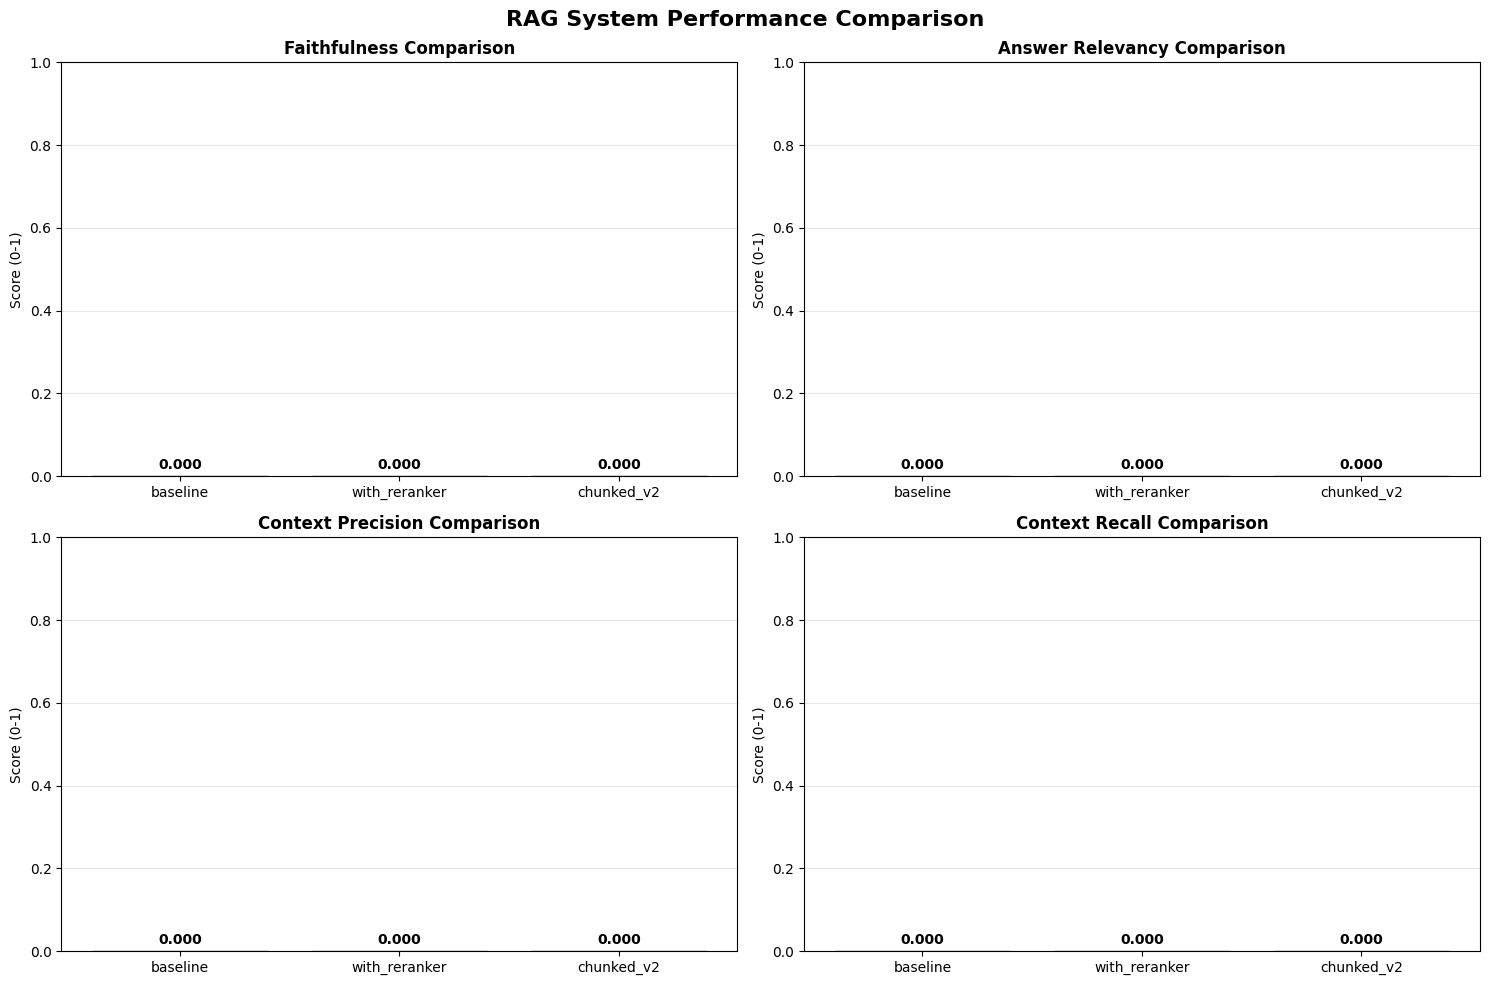

          System  Dataset Size  Faithfulness  Answer Relevancy  \
0       baseline             5             0                 0   
1  with_reranker             5             0                 0   
2     chunked_v2             5             0                 0   

   Context Precision  Context Recall  
0                  0               0  
1                  0               0  
2                  0               0  

📊 DETAILED PERFORMANCE ANALYSIS

🏆 SYSTEM RANKINGS:

Faithfulness:
  1. baseline: 0.000
  2. with_reranker: 0.000
  3. chunked_v2: 0.000

Answer Relevancy:
  1. baseline: 0.000
  2. with_reranker: 0.000
  3. chunked_v2: 0.000

Context Precision:
  1. baseline: 0.000
  2. with_reranker: 0.000
  3. chunked_v2: 0.000

Context Recall:
  1. baseline: 0.000
  2. with_reranker: 0.000
  3. chunked_v2: 0.000

🥇 BEST OVERALL SYSTEM:
   baseline (Avg: 0.000)

💡 RECOMMENDATIONS:
   • Low faithfulness scores suggest hallucination issues
     → Consider improving context quality or usi

In [16]:
# Run the full comparison
results = comparator.evaluate_all()
comparison_df = comparator.visualize_comparison()
print(comparison_df)
comparator.print_detailed_analysis()

In [11]:
# Debug cell - run this to see what the result object looks like
for name, data in comparator.results.items():
    if data['metrics'] is not None:
        print(f"\n{name} metrics:")
        print(f"Type: {type(data['metrics'])}")
        print(f"Contents: {data['metrics']}")
        print(f"Available methods: {[method for method in dir(data['metrics']) if not method.startswith('_')]}")
        break  # Just check the first one


baseline metrics:
Type: <class 'ragas.dataset_schema.EvaluationResult'>
Contents: {'faithfulness': 0.8333, 'answer_relevancy': 0.9985, 'context_precision': 0.6000, 'context_recall': 0.4000}
Available methods: ['binary_columns', 'cost_cb', 'dataset', 'ragas_traces', 'run_id', 'scores', 'to_pandas', 'total_cost', 'total_tokens', 'traces']
